## Notes on work in progress

New here? Perhaps skip down to the **Introduction**. 

### Some ideas; stuff to do


* Ascent versus Descent scatter chart in relation to y = x
* Mean / variance of chlorophyll with depth over time (also by time of day)
* Curtain plot


### Lat / Lon by Site

```
Site                    Lat               Lon
------------------      ---               ---
Oregon Offshore        44.37415        -124.95648
Oregon Slope Base      44.52897        -125.38966 
Axial Base             45.83049        -129.75326
```   

### On MODIS 


- We have Oregon Slope Base MODIS surface chlorophyll for two months in summer 2019
  - June-September time frame, ~13 observations separated by 8 day intervals
  - Other locations? Time ranges? 
- MODIS pixels are < 0.5 degrees latitude (56km). 
  - Double check; and this seems low in comparison with MODIS-native (500m Rob thinks)
  - Pixel blocks of interest? Eddy structure visible? 

# Introduction


`yodapy` is a contraction of **Y**our **O**cean **DA**ta **PY**thon library. It was written 
by Don Setiawan as an abstraction layer to make it easier to work with **OOI** data in Python, 
i.e. easily from code rather than painfully by hand. This notebook reviews 
`yodapy` specific to Regional Cabled Array (RCA) chlorophyll data; but it should apply as well 
to other OOI segments and data types.  


## Notebook features


- demonstrate some plotting utilities of `matplotlib`
- demonstrate working with `xarray` `DataArrays` and `Datasets` (composed from `DataArrays`) 
- Walk-through: Locating, ordering, downloading and using data from OOI
  - particularly from the Regional Cabled Array (RCA)
  - data are in NetCDF format, a good match to `xarray` 



In [1]:
# Run this; standard boilerplate
#

import sys
import os
import timeit
from datetime import timedelta, datetime
from random import randint as ri

from matplotlib import pyplot as plt

import pandas as pd
import netCDF4
import xarray as xr
import dask
import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from ftplib import FTP
from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import utm
# from osgeo import gdal 
# from pygeotools.lib import iolib,timelib

# Local application/library specific imports
from golive_library import GoliveLibrary as g

## Configuring `yodapy`


### OOI data access back-story


To order data from **OOI** requires you to pre-register (free, uses your email address). This provides you with 
credentials to authenticate with when you place a data order. Orders typically take a few minutes for the OOI
servers to assemble; after which you receive email with a download link. You download the data to local storage
and read files into memory and proceed from there, a very labor-intensive process.


### How `yodapy` helps


[`yodapy`](http://github.com/cormorack/yodapy) helps you automate OOI data access at each step. 
It sets up a credentials directory within your home directory;
and in so doing helps you avoid accidentally pushing your credentials to `github` where they would be public. `yodapy` 
allows you to create a Python object called an `OOI()` that includes methods for finding sensor data of interest; 
for ordering time-bounded datasets for those sensors; for downloading this data; and for attaching it to a data 
structure (an `xarray Dataset`) for further analysis. It is at this point when you have your data present as a 
`Dataset` that `yodapy` has completed its job. 


The next cell installs `yodapy`. Run this each time you start up this notebook server unless your installation
of the `yodapy` library persists. 


### Setting up OOI credentials


This notebook assumes you created a User account with OOI as follows:


- Visit the [OOI website](https://ooinet.oceanobservatories.org/#)
- On the login menu (upper right) select **Register**
- Fill out the New User Registration Form
- Once you have your login credentials: Log in
- The 'Login' menu should be replaced with your User name at the upper right: Also a dropdown menu
  - Use this menu to select User Profile
- At the bottom of your User Profile page you should find **API Username** and **API Token**
  - These two strings comprise your authentication 
  - Keep them somewhere safe
  - Notice that the **Refresh API Token** button permits you to regenerate them whenever you like


Use your OOI API Token with `yodapy` as described further down to automate your authentication process.
If this works as intended you can safely use OOI and not have to worry about cutting and pasting these
token strings every time you want to get data access.

In [3]:
# Ensure that the latest build of yodapy is installed directly from github using
# !pip install git+https://github.com/cormorack/yodapy.git

If you are returning to this notebook to continue a `yodapy` project: Skip the next cell. 
Un-comment and run the next cell if...
- ...you want to check that `yodapy` is installed (if not: Run the pip install above)
- ...you need to configure your OOI credentials (do this once; the results should persist across sessions)

In [4]:
# from yodapy.utils.creds import set_credentials_file

### Setting up your OOI credentials using `yodapy`


Only the first time through here: Carefully follow the instructions in the Python cell below.
What you are doing is temporarily telling `yodapy` what your `OOI username` and `token` are. 
`yodapy` creates a hard-to-notice sub-directory of your home directory
that contains these credentials in a text file. As long as you are not publishing
your home directory someplace public your credentials will be hidden away,  
not public. 


#### 'Why am I doing this?'


Later on, when you tell `yodapy` to order data from OOI: `yodapy` knows to use this 'hidden away' copy
of your credentials to convince OOI that your order is legitimate.  

In [12]:
# Run the next line to create authentication credentials for the OOI data system. Do this
# by ***carefully**** substituting your actual credentials in the username and token strings
# in this line of code:


# set_credentials_file(data_source='ooi', username='OOIAPI-XXXXXXXXXXXXXX', token='XXXXXXXXXXXX')


# Un-comment the code and run the cell, just the one line above.
# Once it runs: Comment it out again and delete your credentials. You can obscure them with XXXXX as they are seen now.
# After you obscure your credentials: Be sure not to run this code again as it will break your authentication info.
#
# You can verify this worked by examining the .credentials file in ~/.yodapy. The credentials should match. Notice that 
#   this (slightly hidden) directory is directly connected to your home directory; whereas this IPython notebook 
#   is presumably in a distinct directory; so there should be no chance of a GitHub push sending your 
#   credentials to GitHub. 

### Relocate this comment 


At a low level parquet breaks data in column-wise storage, many small files. Notice this is column-format, not 
row format as we are accustomed to in CSV files. When you read this into dask... a pandas data frame reads the 
entire file... but dask works on lazy eval so dask access to a parquet data ensemble (many of these small chunked 
files) is very efficient as lazy eval. 


Dask reads this data into a dask data frame (which we can consider virtualized / lazy); and a dask data frame is 
analogous to a pandas data frame with that virtualization. 


Athena gives an analogous end-result; it is an AWS service running Apache Hive under the hood. 
You are charged for every query, beware. The access protocol is a SQL query. 

## Create a `yodapy` OOI instance

The ooi instance will enable you to connect to data resources and get datasets. 

In [4]:
# run this DEFINITELY!
from yodapy.datasources import OOI
ooi = OOI()

# Run this to see all the components or segments of OOI available
# ooi.sites

In [5]:
# Use the 'directory with no underscores' method to see what ooi can do (about 30 methods)
g.dirnou(ooi)

['annotations',
 'cava_arrays',
 'cava_infrastructures',
 'cava_instruments',
 'cava_parameters',
 'cava_sites',
 'check_status',
 'clear',
 'clear_cache',
 'data_availability',
 'deployments',
 'download_netcdfs',
 'end_date',
 'global_ranges',
 'instruments',
 'last_m2m_urls',
 'last_requests',
 'ooi_token',
 'ooi_username',
 'raw',
 'regions',
 'request_data',
 'search',
 'sites',
 'source_name',
 'start_date',
 'to_xarray',
 'view_instruments',
 'view_regions',
 'view_sites']

## `ooi.search()` first example


We will begin using `yodapy` proper to narrow down a data search. 


### What resources are available?


Specifically what are the names of sites served by the Regional Cabled Array? 
We begin with a broad search giving only the keyword `region`. 
Then we narrow the search by adding including keywords `site`, `node`, and `instrument` 
to arrive at individual *instruments* or *sensors*. These search results are used to order 
datasets with a specified time range. 


This first example is the broad search. 

In [6]:
skip_this_cell = True

In [7]:
if not skip_this_cell: 
    # ooi.search(region='endurance')
    ooi.search(region='cabled')

In [8]:
if not skip_this_cell: 
    # Attribute 'sites' gives broad results as a table of arrays, sites, descriptions, lat/lon: Across all of OOI (62 rows)
    ooi.sites        

In [9]:
if not skip_this_cell: 
    # Narrow result: Within the Cabled Array region only (116 rows, 6 named columns)
    ooi.instruments

## The notion of a refined OOI search in `yodapy`


The `OOI()` object provided by `yodapy` starts out in a very *broad view* state. It "knows about" the entire OOI: 
Endurance, Pioneer, Argentine Basin, the Cabled Array, Irminger Sea, Station Papa and so on. 


When we use the `.search()` method with keywords we are in effect narrowing down what the `OOI()` object knows 
about. In this code the `OOI()` object is called `ooi` so a search looks like `ooi.search(keyword = 'search string', etc)`. 
After this runs the internal state of `ooi` changes to reflect the search results: It knows about less.


Once we have found a very specific search result of interest the `ooi` object can issue a data request 
using `ooi.request_data(...args...)`.  This data request will use the narrowed-down search perspective 
so as not to order extraneous data. Ideally each data request is focused on only one instrument. This 
helps organize data access within the code.

## `ooi.search()` second example

We narrow the search using keywords `site`, `node` and `instrument`. 
The `ooi.instruments` result from above provides the vocabulary to use for keyword arguments: 

- `site` keyword is taken from the `site_name` column
  - for example `Oregon Slope Base Seafloor` suggests using `oregon slope base` as the keyword value
- `node` keyword is taken from the `infrastructure_name` column
  - for example 'Shallow Profiler (SF01A)` suggests keyword `shallow profiler` (notice these are not case-sensitive)
- `instrument` keyword is taken from the `instrument_name` column
  - for example `3-Wavelength Fluorometer` suggests keyword `fluorometer`
  


Once the narrow search runs we look at the `ooi.instruments` attribute to see how narrow the results are.
This prints as a table where -- as in example one -- the results are sorted into *one instrument per row*.
This can confirm whether the objective of narrowing the search down to a single instrument was met.


We run the `.data_availability()` method. This gives two outputs: A **table** and below that a 
**time series graphic**.  The table lists each instrument as a separate column. These columns are 
then transposed for the time series graphic: One row of boxes for each instrument. 


***Detail: The green `.data_availability()` chart may fail to render in some cases. Re-running the cell might help.***


In [30]:
if not skip_this_cell: 
    ooi.search(region='endurance', site='oregon offshore', node='shallow profiler', instrument='fluorometer')

<Data Source: OOI (1 Instrument Stream)>

In [31]:
if not skip_this_cell: 
    ooi.instruments

,array_name,site_name,infrastructure_name,instrument_name,stream_method,stream_rd
0,Coastal Endurance,Oregon Offshore Cabled Shallow Profiler Mooring,Shallow Profiler (SF01B),3-Wavelength Fluorometer,streamed,flort_d_data_record


,CE04OSPS-SF01B-3A-FLORTD104-streamed-flort_d_data_record
0,Coastal Endurance
1,Oregon Offshore Cabled Shallow Profiler Mooring
2,Shallow Profiler (SF01B)
3,3-Wavelength Fluorometer
4,streamed
5,flort_d_data_record


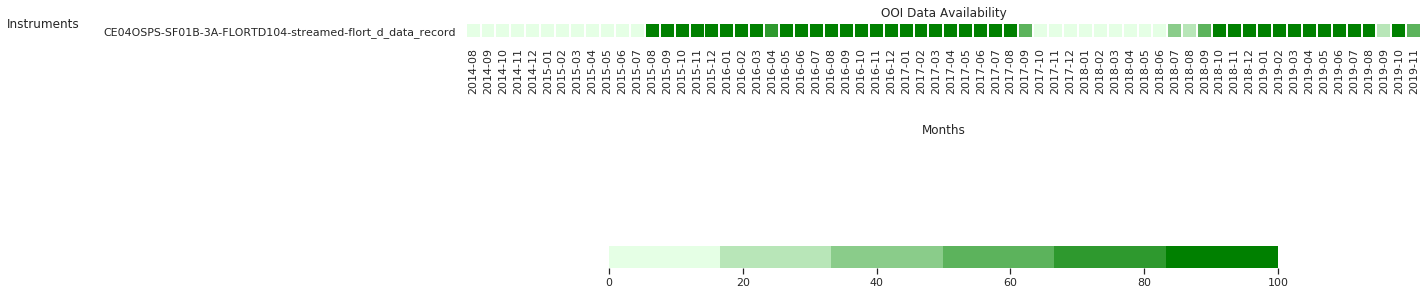

In [32]:
if not skip_this_cell: 
    ooi.data_availability()

In [34]:
# run this to see fluorometers available at Oregon Offshore (without using the 'node' keyword)
# 
#   filters endurance + oregon offshore + fluorometer turn up 7 hits...
#     2 are Oregon Offshore Surface Mooring: 3 wavelength... of future interest in expanding the MODIS connection
#     2 are Oregon Offshore deep profiler CDOM fluorometer
#     2 are Oregon Offshore deep profiler 2 wavelength...    of future interest also (not sure if this is on the RCA)
#     1 is Oregon Offshore shallow profiler 3 wavelength     *** Current interest: RCA MODIS connect ***
#
# ooi.search(region='endurance', site='oregon offshore', instrument='fluorometer')
# ooi.instruments
# ooi.data_availability()

,RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record
0,Cabled Continental Margin (Cabled Array)
1,Oregon Slope Base Shallow Profiler Mooring
2,Shallow Profiler (SF01A)
3,3-Wavelength Fluorometer
4,streamed
5,flort_d_data_record


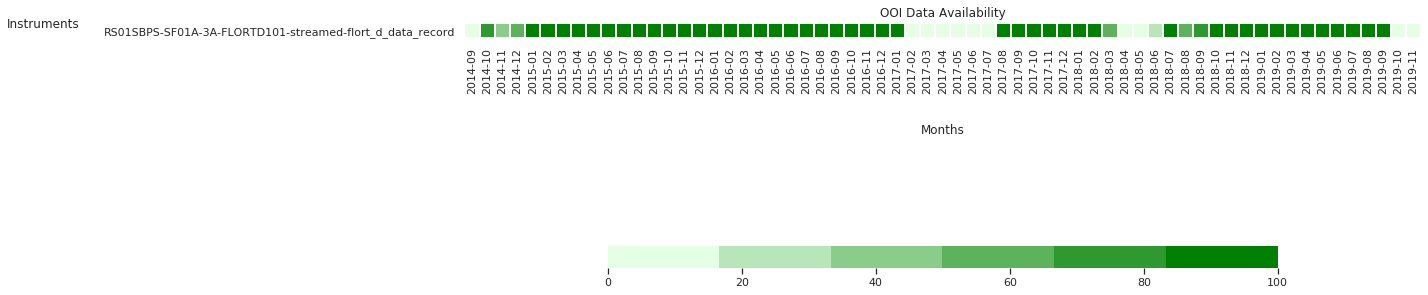

In [35]:
# This ooi.search() call: 
# 
# ooi.search(region='cabled', instrument='fluorometer') 
# 
# produces 12 hits. Here is the breakdown; where results suggest site and node search keywords. 
#  Note that Deep Profiler sites have degeneracy in 'recovered_inst' versus 'recovered_wfp' (appear twice)
# 
#     - (4) Axial Base Deep Profiler Mooring (CDOM Fluorometer,  2-Wavelength Fluorometer)
#     - (4) Oregon Slope Base Deep Profiler Mooring (CDOM Fluorometer, 2-Wavelength Fluorometer)
#     - (1) Oregon Slope Base Shallow Profiler Mooring (200m Platform; 2-Wavelength Fluorometer)
#     - (1) Oregon Slope Base Shallow Profiler Mooring (Shallow Profiler; 3-Wavelength Fluorometer)
#     - (1) Axial Base Shallow Profiler Mooring (200m Platform; 2-Wavelength Fluorometer)
#     - (1) Axial Base Shallow Profiler Mooring (Shallow Profiler; 3-Wavelength Fluorometer)

# Resulting searches: Choose one of these...
ooi.search(region='cabled', site='oregon slope base', node='shallow', instrument='fluorometer')
# ooi.search(region='cabled', site='oregon slope base', node='200m', instrument='fluorometer')
# ooi.search(region='cabled', site='axial base', node='shallow', instrument='fluorometer')
# ooi.search(region='cabled', site='axial base', node='200m', instrument='fluorometer')

# ...and run...
if not skip_this_cell: 
    ooi.data_availability()

## transition to data request

The following cells include code for requesting data from OOI. From this point onward the 
narrative will be less detailed. 

In [5]:
# Assume the above cell narrowed the search results to a single instrument. Assume also that we 
#   are interested in June 1 -- September 15 of 2019. We now use the ooi object to generate a 
#   data request.
#
# .request_data() generates a data request
# .to_xarray() polls the OOI system until the order completes; this will take a couple of minutes
#
# begin_date = '2019-06-01'
# end_date = '2019-09-15'
# ooi.request_data(begin_date=begin_date, end_date=end_date)
# ds = ooi.to_xarray()
# len(ds)

In [6]:
# run this to download the data (possibly multiple files) from a completed data request from above
# 
# filenamelist = ooi.download_netcdfs()
# len(filenamelist)

## transition to data management


### What is the issue here? 


This narrative is provided as an IPython notebook (really a Jupyter notebook) which resides in 
a Linux sub-directory of the User home directory `~`. This sub-directory is bundled using
the `git` utility as an open source repository ('repo') backed up by 
[`github`](https://github.com/robfatland/chlorophyll).
The github service constrains repository size with the idea of backing up code, not data. 


So far so good. The data considered here exceeds 1GB and needs to be placed elsewhere in the 
working environment; in fact within a `data` sub-directory not part of the `chlorophyll`
repo. We outline one approach for doing this here using the Linux command line, available
through a terminal window provided in the Jupyter environment. 



### File resources


The code above pulls NetCDF files to a local `chlorophyll` repository directory. 
In practice this `github` repository directory does not have capacity for 
large data files (hundreds of MB). To deal with this (at the moment) we relocate 
the data files outside the repository and access them by creating symbolic 
links. Here is a sketch of the directory structure:


```
home directory ~ has sub-directories:

.yodapy                    chlorophyll                    data

(OOI credentials)          (IPython notebooks)            sub-dir 'chlorophyll'

                                                              sub-dir 'OregonSlopeBase'
                                                          
                                                                  sub-dir 'ShallowProfiler'
                                                          
                                                                      ...includes 730MB of data
```


The symbolic link command looks like this, noting the distinction between `chlorophyll`
as a sub-directory of `data` versus `chlorophyll` as the repository directory:


```
ln -s ~/data/chlorophyll/SiteDir/InstrumentDir/filename.nc ~/chlorophyll/Identifier_00XX.nc
```


The code uses the `xarray` (multi-file) `xr.open_mfdataset("Identifier*.nc")` Dataset generator to 
open possibly multiple files as a single `Dataset`. 


These data are (upon arrival) ordered under dimension = observation number `obs`.
The data are immediately modified to use dimension = `time`.


Here is the current state of data holdings in this environment:


```
SymLink                                 Site               Instrument  Sensor        Got it
-----------                             ---------          ----------  ---------     ---------
OreOff_ShallProf_Fluor_000*.nc          Oregon Offshore    shallow     fluor chlor     X        

OreSlope_ShallProf_Fluor_000*.nc        Oregon Slope Base  shallow     fluor chlor     X  
OreSlope_200m_Fluor_000*.nc             Oregon Slope Base  200m        fluor chlor     X

AxialBase_ShallProf_Fluor_000*.nc       Oregon Slope Base  shallow     fluor chlor     X
AxialBase_200m_Fluor_000*.nc            Oregon Slope Base  200m        fluor chlor     not yet
AxialBase_DeepProf_Fluor_000*.nc        Oregon Slope Base  deep        fluor chlor     not yet
```


In [10]:
# run this; not part of boilerplate to call out specific use of xarray

import xarray as xr

## MODIS intermezzo 


Before continuing with the OOI data we take a moment to bring in MODIS estimates 
of surface chlorophyll at the Oregon Slope Base site. There are ten valid
observations between June 2 and August 29, 2019. 


This section also serves as an example of building an `xarray Dataset` by hand.


In [11]:
# MODIS dates of observation
mdate = [dt64('2019-06-02T11:15:00.0'), \
         dt64('2019-06-10T11:55:01.0'), \
         dt64('2019-06-18T11:15:00.0'), \
         dt64('2019-06-26T11:55:01.0'), \
         dt64('2019-07-04T11:15:00.0'), \
         dt64('2019-07-12T11:55:01.0'), \
         dt64('2019-07-20T11:15:00.0'), \
         dt64('2019-07-28T11:55:01.0'), \
         dt64('2019-08-05T11:15:00.0'), \
         dt64('2019-08-13T11:55:01.0'), \
         dt64('2019-08-21T11:15:00.0'), \
         dt64('2019-08-29T11:55:01.0')]

# MODIS corresponding surface chlorophyll estimates
mchl = [0.3483194, 0.49131608, 0.48018616, np.nan, np.nan, 0.2037715, 0.26320615, 0.3066225, \
        0.35098818, 0.579521, 0.67963886, 0.58974856]

# Translating these two lists into a MODIS DataArray
mda = xr.DataArray(mchl, dims=('time'), coords={'time': mdate})
mda

<xarray.DataArray (time: 12)>
array([0.348319, 0.491316, 0.480186,      nan,      nan, 0.203771, 0.263206,
       0.306623, 0.350988, 0.579521, 0.679639, 0.589749])
Coordinates:
  * time     (time) datetime64[ns] 2019-06-02T11:15:00 ... 2019-08-29T11:55:01

In [12]:
# Noting that the .values attribute provides an array of floats
print(mda.values)
print()
print(mda.values[0])
print()
print('The mean of the numerical values is ' + "%5.3f" % mda.values[~np.isnan(mda.values)].mean())

[0.3483194  0.49131608 0.48018616        nan        nan 0.2037715
 0.26320615 0.3066225  0.35098818 0.579521   0.67963886 0.58974856]

0.3483194

The mean of the numerical values is 0.429


### deconstructing that print statement

- `"%5.3f" % x` is a format statement for printing a float value `x`. 
- `mda.values` is a `numpy ndarray` (and not a list)
- `np.isnan(...ndarray...)` is also a `numpy ndarray`: Of boolean values `True` or `False` for each source element
  - `True` means the element is a `nan`; so no valid data present
- `~np.isnan(...ndarray...)` is a `numpy ndarray` where the logical values are flipped; so now `True` means valid data present
- `mda.values[...boolean ndarray...]` is a logically reduced version of `mda.values` with all of the `nan` elements removed (as `False`)
- `mda.values[...].mean()` is the mean of the resulting `ndarray`

In [13]:
mda.dims

('time',)

In [14]:
mda.coords

Coordinates:
  * time     (time) datetime64[ns] 2019-06-02T11:15:00 ... 2019-08-29T11:55:01

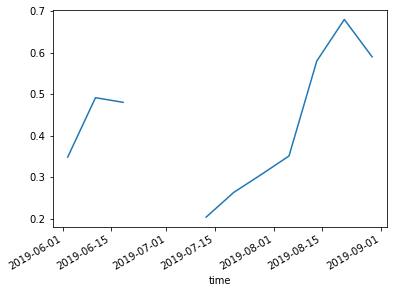

In [16]:
mda.plot()

In [17]:
mds = xr.Dataset({'MODIS chlorophyll': mda})
mds

<xarray.Dataset>
Dimensions:            (time: 12)
Coordinates:
  * time               (time) datetime64[ns] 2019-06-02T11:15:00 ... 2019-08-29T11:55:01
Data variables:
    MODIS chlorophyll  (time) float64 0.3483 0.4913 0.4802 ... 0.6796 0.5897

### End of MODIS intermezzo; returning to Cabled Array fluorometer data

Multiple local data files can be opened at this point as a single Dataset using `xarray`:

```
ds=xr.open_mfdataset(...filename description string...)
ds = ds.swap_dims({'obs':'time'})
```

This swaps out observation number in favor of time as the operative dimension. 

In [18]:
# This version uses wildcard notation on pre-existing data files
# Endurance array 'Oregon Offshore' site data, 200 meter platform at Oregon Slope Base, Axial Base shallow profiler
#   ds = xr.open_mfdataset('/home/jovyan/chlorophyll/OreOff_ShallProf_Fluor_000*.nc')
#   ds = xr.open_mfdataset('/home/jovyan/chlorophyll/OreSlope_200m_Fluor_000*.nc')
#   ds = xr.open_mfdataset('/home/jovyan/chlorophyll/AxialBase_ShallProf_Fluor_000*.nc')

# Cabled Array 'Oregon Slope Base' site data:
ds = xr.open_mfdataset('/home/jovyan/chlorophyll/OreSlope_ShallProf_Fluor_000*.nc')
ds = ds.swap_dims({'obs':'time'})
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


<xarray.Dataset>
Dimensions:                                          (time: 7202071)
Coordinates:
    obs                                              (time) int64 0 ... 6250485
  * time                                             (time) datetime64[ns] 2019-06-01T00:00:00.339009024 ... 2019-09-14T23:59:59.135749632
    int_ctd_pressure                                 (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
    lat                                              (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
    lon                                              (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
Data variables:
    deployment                                       (time) int32 dask.array<shape=(7202071,), chunksize=(951585,)>
    id                                               (time) |S36 dask.array<shape=(7202071,), chunksize=(951585,)>
    date_string                                      (time) object dask.array<sha

In [19]:
# run this to get a check of the units for chlorophyll 

ds.fluorometric_chlorophyll_a.units

# one can make a quick plot of (say) the chlorophyll with time via
# p = ds.fluorometric_chlorophyll_a.plot()

'µg L-1'

## Remark on Subsequent Sections


To this point we have created a Cabled Array fluormeter Dataset and a corresponding MODIS Dataset. 
Subsequent ***Sections*** will be concerned with analysis.


### Section: Oregon Slope Base Shallow Profiler near-surface only


The Oregon Slope Base site has a depth of about 2900 meters and is located at the base of the continental shelf 
west of Oregon. The fluorometer data are collected over the course of a day as nine profile runs from a depth
of 200 meters to near the surface. Between profiles that profiler pod is at rest on a platform that is always
at a depth of 200 meters. The sampling rate is a little less than on sample per second. 


The objective in this section is to create an approximate record of near-surface chlorophyll (all measurements 
above say 25 meter depth) and compare that with the MODIS values for the same site. 

In [20]:
ds.dims

Frozen(SortedKeysDict({'time': 7202071}))

In [21]:
ds.coords

Coordinates:
    obs               (time) int64 0 1 2 3 4 ... 6250482 6250483 6250484 6250485
  * time              (time) datetime64[ns] 2019-06-01T00:00:00.339009024 ... 2019-09-14T23:59:59.135749632
    int_ctd_pressure  (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
    lat               (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
    lon               (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>

In [22]:
# run this to see some example sample times at the start and end of the Dataset
# ds.time[0:20], ds.time[-20:-1]

### A little poking around in the Dataset

These lines generate a timedelta64 result; where the .item() method requires further digging to understand.
All of these indicate 1.128 seconds between samples

```
(ds.time[1].values-ds.time[0].values).item()*1.e-9             # inter-sample interval in seconds
(ds.time[-1].values-ds.time[-2].values).item()*1.e-9           # and the same at the end; same result
(ds.time[1901000].values-ds.time[1900000].values).item()*1.e-9*1.e-3           # longer interval
```

Latitude and longitude are fixed.

```
print(len(ds.lat))
ds.lat[3000000:3000007].values              # all the same, all seven million copies
```

In [29]:
# dss is Dataset subset: using where() to select for the shallow depth range, "above so-many meters"
#
# < 25 gives 383k points
# < 20 gives 278k points
# < 15 gives 144k points
# < 10 gives 44k points 

dss=ds.where(ds.int_ctd_pressure < 25., drop=True)

In [30]:
dss.dims, ds.dims

(Frozen(SortedKeysDict({'time': 383070})),
 Frozen(SortedKeysDict({'time': 7202071})))

In [31]:
chlor_a = dss.fluorometric_chlorophyll_a
print(type(chlor_a))                         # will be a DataArray
pressure = dss.int_ctd_pressure
# t0 = dt64('2019-06-15T00:00')
t0 = dt64('2019-07-10T00:00')                # slightly precedes the second (contiguous) MODIS data interval
t1 = dt64('2019-09-01T00:00')
print(t0)

<class 'xarray.core.dataarray.DataArray'>
2019-07-10T00:00


In [32]:
time_x_axis = dss.time
type(time_x_axis)

xarray.core.dataarray.DataArray

In [33]:
# the .rolling() method culls out 600 consecutive values at a time; whereupon .mean() is applied
dss_chlor_mean = dss.fluorometric_chlorophyll_a.rolling(time=600, center=True).mean()

# This also works to produce locally minimal data; but it is not very interesting
# dss_chlor_min = dss.fluorometric_chlorophyll_a.rolling(time=600).min()

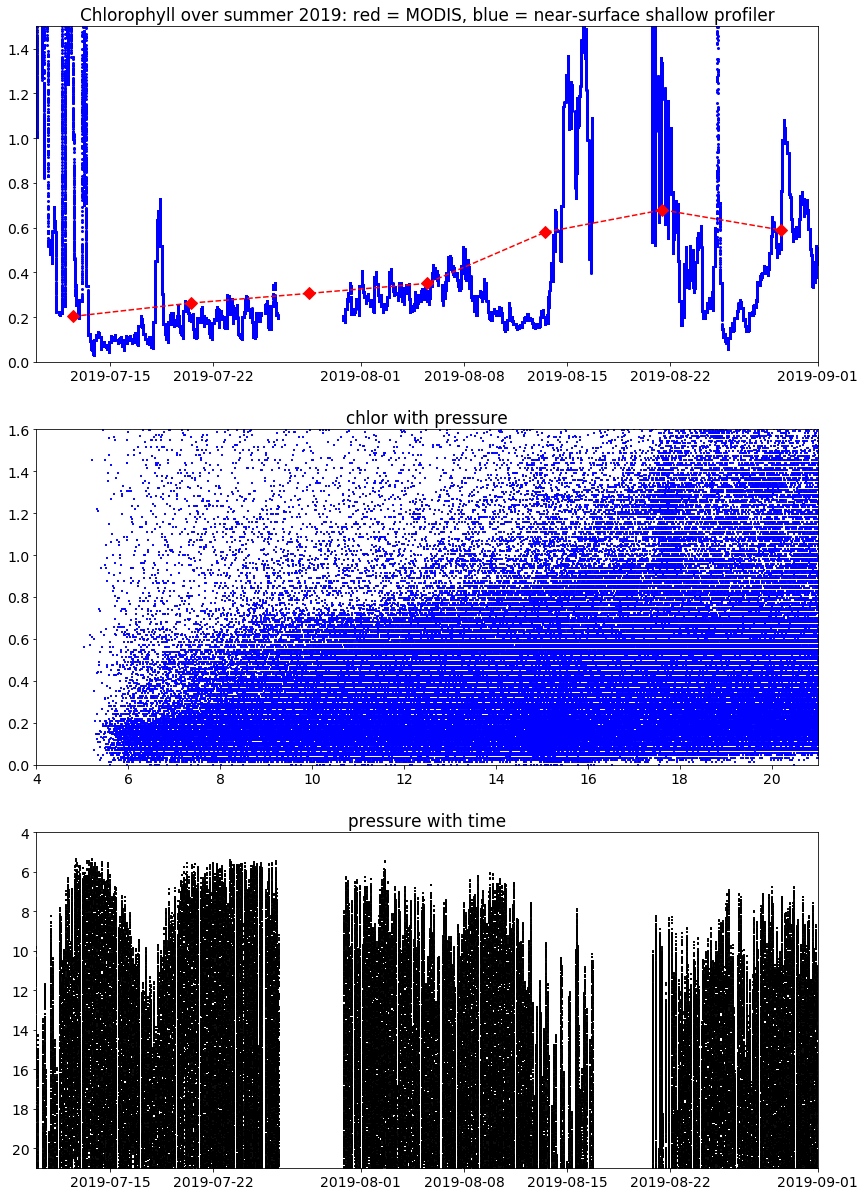

In [41]:
p,a=plt.subplots(3, 1, figsize=(14,21))
plt.rcParams.update({'font.size': 14})

# This works to produce a line plot for shallow profiler chlorophyll (rolling mean): 
# a[0].plot(time_x_axis, dss_chlor_mean, color='b')
a[0].scatter(time_x_axis.values, dss_chlor_mean, color='b', marker= 'o', s = 4.0)
a[1].scatter(pressure, chlor_a, color='b', marker= ',', s = 1.0) 
# a[2].plot(time_x_axis, pressure, color='k') 
a[2].scatter(time_x_axis.values, pressure, color='k', marker=',', s=1.0) 

a[0].set(ylim=(0., 1.5), xlim = (t0, t1), title='Chlorophyll over summer 2019: red = MODIS, blue = near-surface shallow profiler')
a[1].set(ylim=(0., 1.6), xlim = (4., 21.), title='chlor with pressure')
a[2].set(ylim=(21., 4.), xlim = (t0, t1), title='pressure with time')

a[0].plot(mda.time, mda, color='r', marker='D', markersize = 9., linestyle='dashed')
# a[0].scatter(np.datetime(mda.time), mda, color='r', marker= ',', s = 36.0)

In [46]:
# spare code; delete probably

# plt.rcParams.update({'font.size': 10})
# p,a=plt.subplots(3, 1, figsize=(14,21))
# a[0].plot(time_x_axis, dss_chlor_mean, color='b')
# a[0].scatter(time_x_axis.values, dss_chlor_mean, color='b', marker= ',', s = 5.0)
# a[1].scatter(pressure, chlor_a, color='b', marker= ',', s = 1.0) 
# a[2].plot(time_x_axis, pressure, color='k') 

# a[0].set(ylim=(0., 1.5), xlim = (t0, t1), \
#          title='Chlorophyll: red = MODIS, blue = near-surface shallow profiler')
# a[1].set(ylim=(0., 1.6), xlim = (4., 21.), title='chlor with pressure')
# a[2].set(ylim=(21., 4.), xlim = (t0, t1), title='pressure with time')

# a[0].plot(mda.time, mda, color='r', marker='D', markersize = 9., linestyle='dashed')
# a[0].scatter(np.datetime(mda.time), mda, color='r', marker= ',', s = 36.0)

# a[0].set_ylabel('[Chlorophyll] ug L-1')
# a[0].set_xlabel('Date')


### Section: Curtain plot version of shallow profiler scatter

Text(0.5, 0, 'Date')

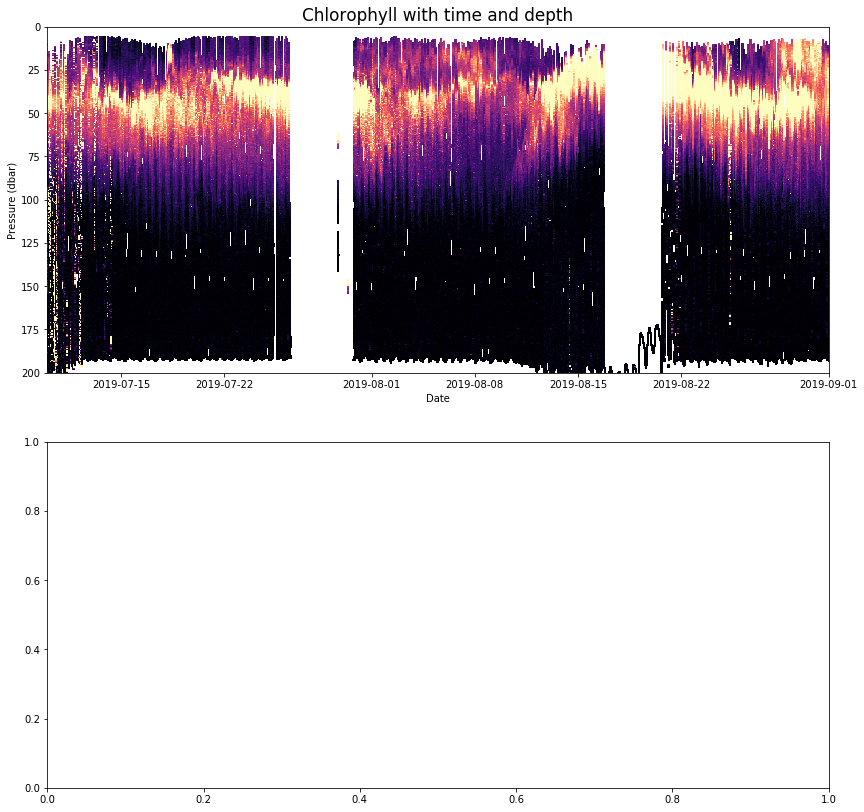

In [54]:
from matplotlib import colors as mplcolors

t0 = dt64('2019-07-10T00:00')                
t1 = dt64('2019-09-01T00:00')

pressure = ds.int_ctd_pressure
time_x_axis = ds.time
chlor = ds.fluorometric_chlorophyll_a

norm = mplcolors.Normalize(vmin=0.0,vmax=0.7)

plt.rcParams.update({'font.size': 10})
p,a=plt.subplots(2, 1, figsize=(14,14))

a[0].scatter(time_x_axis.values, pressure, cmap='magma', c=chlor, norm=norm, marker= ',', s = 1.0)
a[0].set(ylim=(200., 0.0), xlim = (t0, t1))

plt.rcParams.update({'font.size': 14})
a[0].set(title='Chlorophyll with time and depth')
plt.rcParams.update({'font.size': 10})

# a[1].set(ylim=(0., 1.6), xlim = (4., 21.), title='chlor with pressure')
# a[2].set(ylim=(21., 4.), xlim = (t0, t1), title='pressure with time')

# a[0].plot(mda.time, mda, color='r', marker='D', markersize = 9., linestyle='dashed')
# a[0].scatter(np.datetime(mda.time), mda, color='r', marker= ',', s = 36.0)

a[0].set_ylabel('Pressure (dbar)')
a[0].set_xlabel('Date')
# a[0].set_cmap('jet')


## Section: Artifact on setting time range: precise or quantized in days

In [ ]:
do_precision = False

if do_precision:
    
    t0 = dt64('2019-06-01T00:00')
    t1 = dt64('2019-06-01T05:20')
    dss = ds.sel(time=slice(t0, t1))
    
else:
    t0 = dt64('2019-06-24T00:00')
    t1 = dt64('2019-06-28T00:00')
    day1 = '24'
    day2 = '27'              # will be 'day 27 inclusive' I think
    dss = ds.sel(time=slice('2019-06-' + day1, '2019-08-' + day2))

len(dss.time)

### Section on comparatives

Compares Oregon Slope Base 200m Platform... to Axial Base SP... to Oregon Slope Base SP... to Oregon Offshore SP 

In [144]:
# 
# Precision section works with precise times versus day-scale
#   The precise times are an experiment in using 2 hours 40 minutes to chop up the 9 profiles in the day in a regular manner...
#   but a better approach would be to detect the profiles and time-box each one individually. 
# 

do_precision = True

if do_precision:
    
    # t0 = dt64('2019-06-01T00:00')
    # t1 = dt64('2019-06-01T05:20')

    # t0 = dt64('2019-06-01T02:40')
    # t1 = dt64('2019-06-01T07:00')

    # t0 = dt64('2019-06-01T05:20')
    # t1 = dt64('2019-06-01T10:40')

    # t0 = dt64('2019-06-01T07:00')
    # t1 = dt64('2019-06-01T13:20')

    # t0 = dt64('2019-06-01T10:40')
    # t1 = dt64('2019-06-01T16:00')

    # t0 = dt64('2019-06-01T10:40')
    # t1 = dt64('2019-06-01T16:00')

    # t0 = dt64('2019-06-01T10:40')
    # t1 = dt64('2019-06-01T13:20')

    # t0 = dt64('2019-06-01T00:00')
    # t1 = dt64('2019-06-01T02:40')

    # t0 = dt64('2019-06-01')
    # t1 = dt64('2019-06-02')
    
    t0 = dt64('2019-07-20T11:00')
    t1 = dt64('2019-07-20T18:00')

    dss = ds.sel(time=slice(t0, t1))
    
else:
    t0 = dt64('2019-06-24T00:00')
    t1 = dt64('2019-06-28T00:00')

    day1 = '24'
    day2 = '27'              # will be 'day 27 inclusive' I think
    dss = ds.sel(time=slice('2019-06-' + day1, '2019-08-' + day2))

len(dss.time)

21000

[(200.0, 0.0), Text(0.5, 1.0, '   ')]

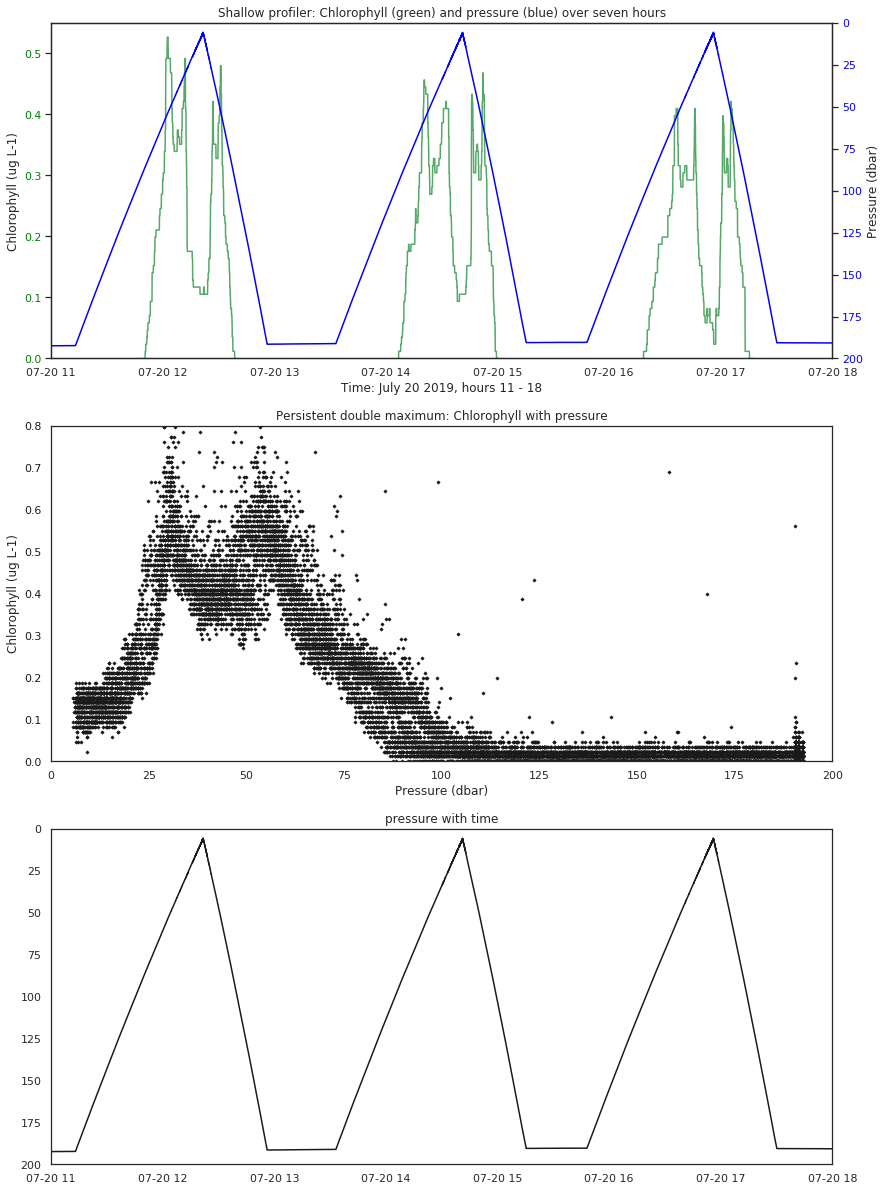

In [153]:
p,a=plt.subplots(3, 1, figsize=(14,21))
plt.rcParams.update({'font.size': 10})
chlor_a = dss.fluorometric_chlorophyll_a
chlor_a_min = chlor_a.rolling(time=60, center=True).min()
pressure = dss.int_ctd_pressure

a[0].plot(dss.time, chlor_a_min, color='g')
a[1].scatter(pressure, chlor_a, color='k', marker= 'D', s = 4.0) 
a[2].plot(dss.time, pressure, color='k') 

a[0].set(ylim=(0., 0.55), xlim = (t0, t1), title='Shallow profiler: Chlorophyll (green) and pressure (blue) over seven hours')
a[1].set(ylim=(0., 0.8), xlim = (0., 200.), title='Persistent double maximum: Chlorophyll with pressure')
a[2].set(ylim=(200., 0.), xlim = (t0, t1), title='pressure with time')

a[0].set_ylabel('Chlorophyll (ug L-1)')
a[0].set_xlabel('Time: July 20 2019, hours 11 - 18')
a[0].tick_params(axis='y', labelcolor='green')

a[1].set_ylabel('Chlorophyll (ug L-1)')
a[1].set_xlabel('Pressure (dbar)')
a[1].tick_params(axis='y', labelcolor='k')

a0p = a[0].twinx()
a0p.set_ylabel('Pressure (dbar)')
a0p.plot(dss.time, pressure, color='blue')
a0p.tick_params(axis='y', labelcolor='blue')
a0p.set(ylim=(200., 0.), title='   ')
# p.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()



# Create some mock data
# t = np.arange(0.01, 10.0, 0.01)
# data1 = np.exp(t)
# data2 = np.sin(2 * np.pi * t)
#
# color = 'tab:red'
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('exp', color=color)
# ax1.plot(t, data1, color=color)
# ax1.tick_params(axis='y', labelcolor=color)
#
#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#
# color = 'tab:blue'
# ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# 
# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

[(200.0, 0.0), (737234.0, 737238.0), Text(0.5, 1.0, 'pressure with time')]

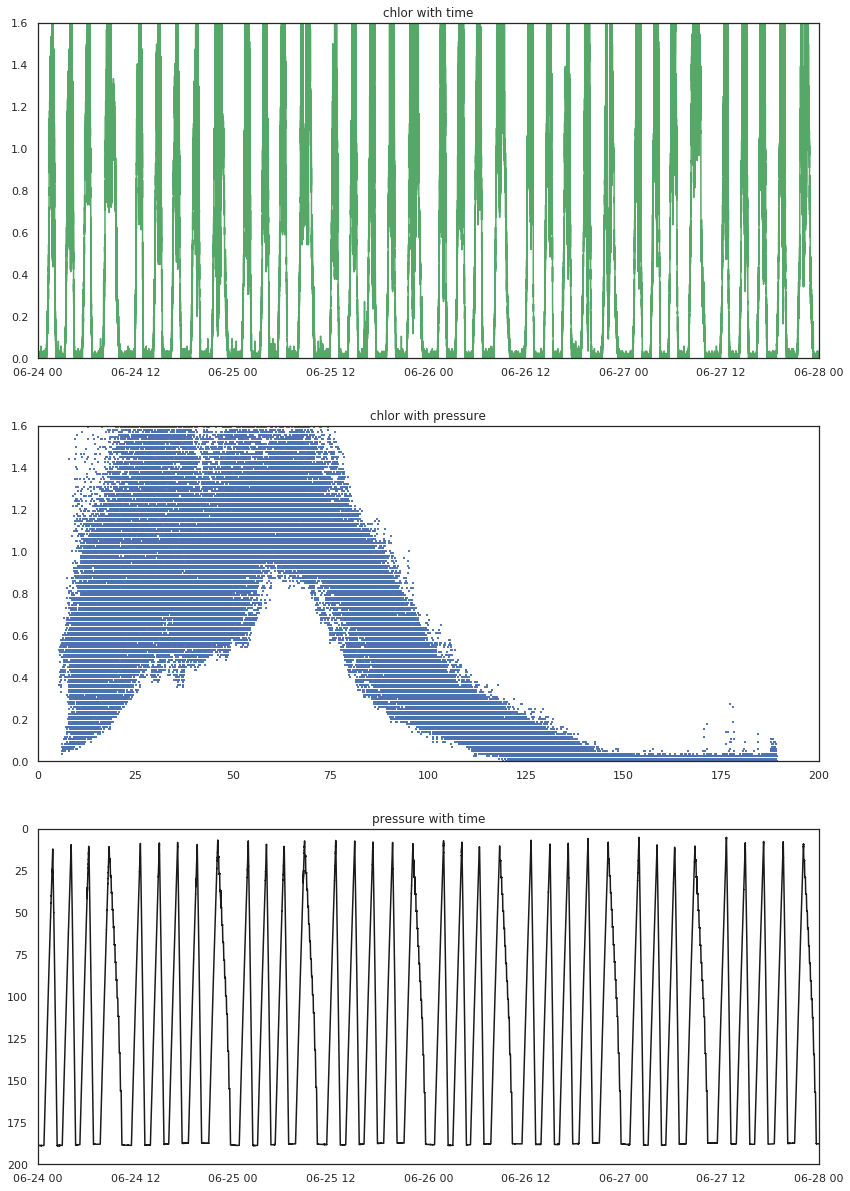

In [51]:
p,a=plt.subplots(3, 1, figsize=(14,21))
plt.rcParams.update({'font.size': 10})
chlor_a = dss.fluorometric_chlorophyll_a
pressure = dss.int_ctd_pressure

a[0].plot(dss.time, chlor_a, color='g')
a[1].scatter(pressure, chlor_a, color='b', marker= ',', s = 1.0) 
a[2].plot(dss.time, pressure, color='k') 

a[0].set(ylim=(0., 1.6), xlim = (t0, t1), title='chlor with time')
a[1].set(ylim=(0., 1.6), xlim = (0., 200.), title='chlor with pressure')
a[2].set(ylim=(200., 0.), xlim = (t0, t1), title='pressure with time')

[(200.0, 0.0), (737234.0, 737238.0), Text(0.5, 1.0, 'pressure with time')]

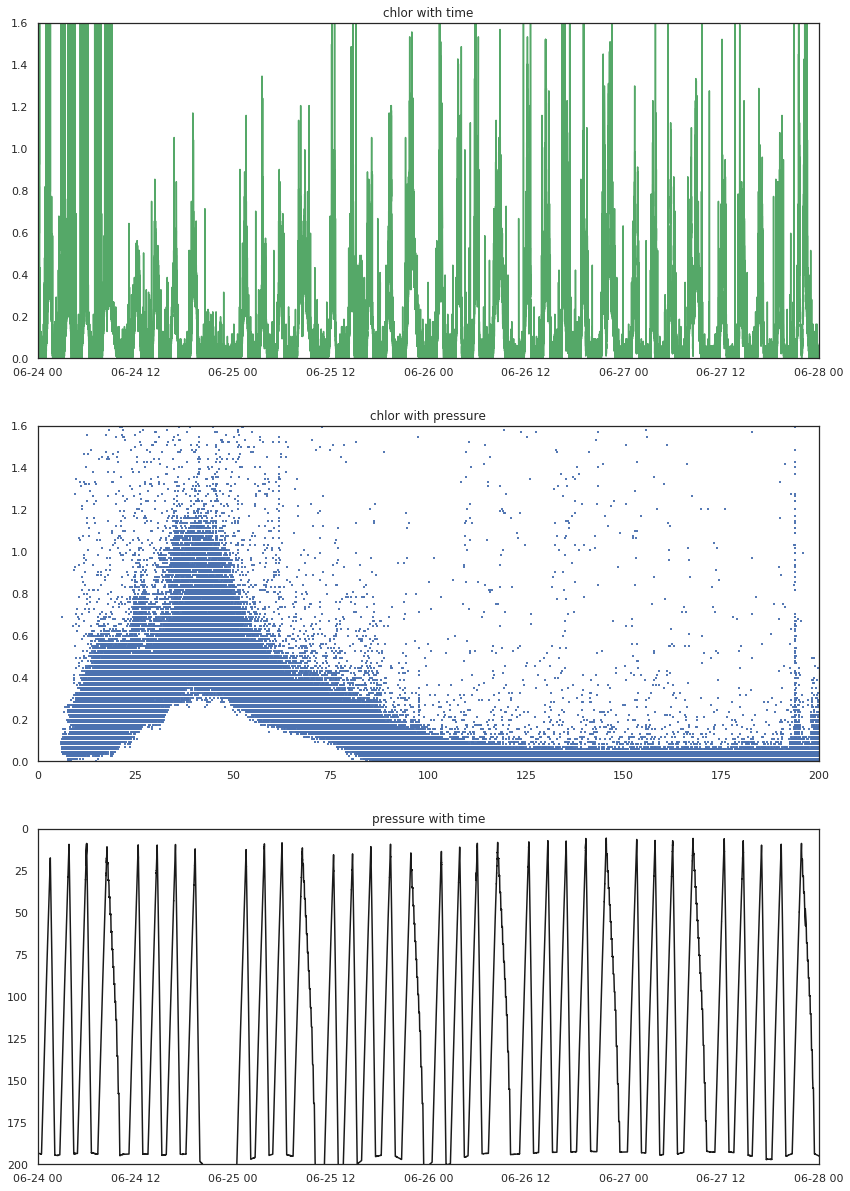

In [38]:
p,a=plt.subplots(3, 1, figsize=(14,21))
plt.rcParams.update({'font.size': 10})
chlor_a = dss.fluorometric_chlorophyll_a
pressure = dss.int_ctd_pressure

a[0].plot(dss.time, chlor_a, color='g')
a[1].scatter(pressure, chlor_a, color='b', marker= ',', s = 1.0) 
a[2].plot(dss.time, pressure, color='k') 

a[0].set(ylim=(0., 1.6), xlim = (t0, t1), title='chlor with time')
a[1].set(ylim=(0., 1.6), xlim = (0., 200.), title='chlor with pressure')
a[2].set(ylim=(200., 0.), xlim = (t0, t1), title='pressure with time')

[(200.0, 0.0), (737234.0, 737238.0), Text(0.5, 1.0, 'pressure with time')]

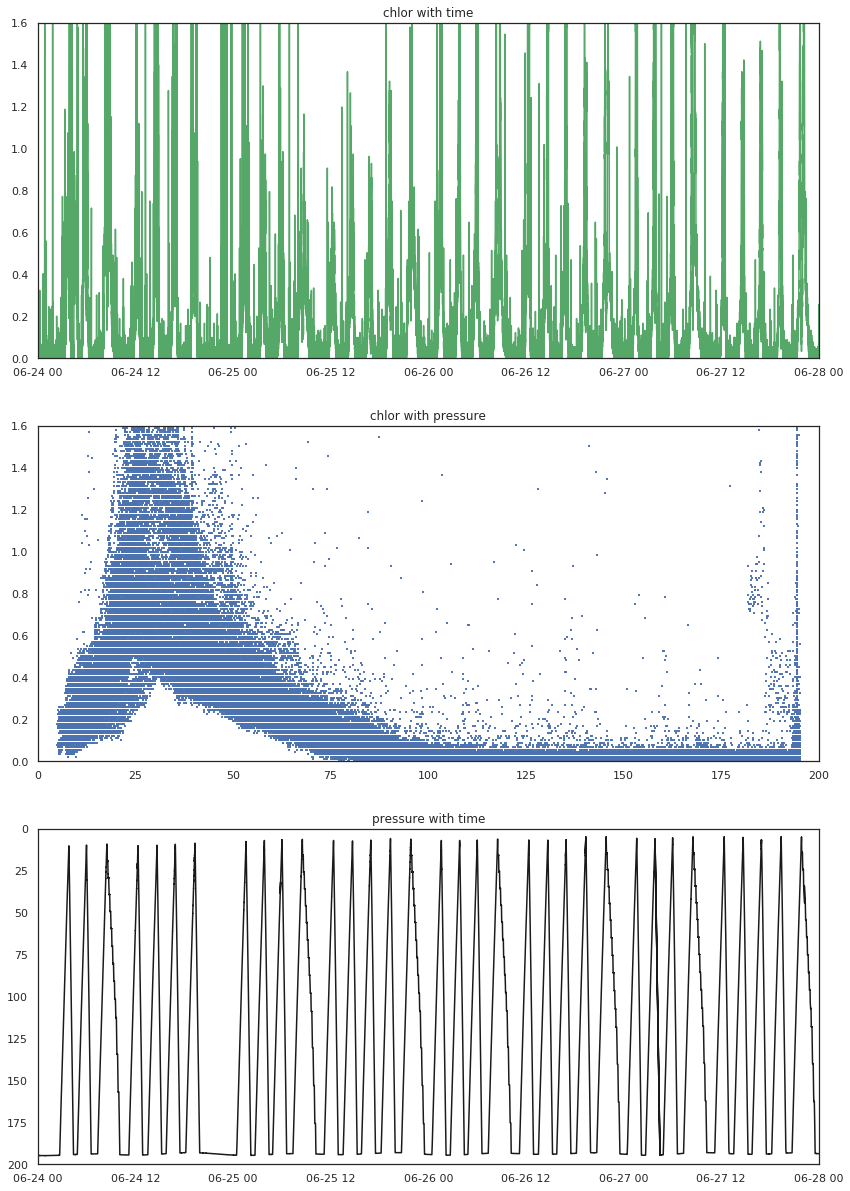

In [42]:
p,a=plt.subplots(3, 1, figsize=(14,21))
plt.rcParams.update({'font.size': 10})
chlor_a = dss.fluorometric_chlorophyll_a
pressure = dss.int_ctd_pressure

a[0].plot(dss.time, chlor_a, color='g')
a[1].scatter(pressure, chlor_a, color='b', marker= ',', s = 1.0) 
a[2].plot(dss.time, pressure, color='k') 

a[0].set(ylim=(0., 1.6), xlim = (t0, t1), title='chlor with time')
a[1].set(ylim=(0., 1.6), xlim = (0., 200.), title='chlor with pressure')
a[2].set(ylim=(200., 0.), xlim = (t0, t1), title='pressure with time')

### Resource code block


This is a 3 x 3 matrix of CTD and related-sensor time series charts from a `data_gallery` IPython notebook. 


```
rn = range(9); rsi = range(7)

p,a=plt.subplots(3, 3, figsize=(14,14))
plt.rcParams.update({'font.size': 10})
a[0,0].plot(ctdF.time, ctdF.depth, color='r');                                  a[0,0].set(ylim=(200.,0.), title='Depth')
a[0,1].plot(ctdF.time, ctdF.salinity, color='k');                               a[0,1].set(title='Salinity')
a[0,2].plot(ctdF.time, ctdF.temperature, color='b');                            a[0,2].set(title='Temperature')
a[1,0].plot(ctdF.time, ctdF.dissolved_oxygen, color='b');                       a[1,0].set(title='Dissolved Oxygen')
a[1,1].scatter(phF.time.values, phF.ph_seawater.values, color='r');             a[1,1].set(title='pH')
a[1,2].scatter(nitrateF.time.values, nitrateF.scn.values, color='k');           a[1,2].set(title='Nitrate')
a[2,0].plot(parF.time, parF.par_counts_output, color='k');                      a[2,0].set(title='Photosynthetic Light')
a[2,1].plot(fluorF.time, fluorF.fluorometric_chlorophyll_a, color='b');         a[2,1].set(title='Chlorophyll')
a[2,2].plot(siF.time, siF.si0, color='r');                                      a[2,2].set(title='Spectral Irradiance')

a[2,0].text(dt64('2017-08-21T07:30'), 155., 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')
a[2,2].text(dt64('2017-08-21T07:30'), 4.25, 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')

tFmt   = mdates.DateFormatter("%H")                 # an extended format for strftime() is "%d/%m/%y %H:%M"
t0, t1 = ctdF.time[0].values, ctdF.time[-1].values  # establish same time range for each chart
tticks = [dt64('2017-08-21T06:00'), dt64('2017-08-21T12:00'), dt64('2017-08-21T18:00')]

for i in rn: j, k = i//3, i%3; a[j, k].set(xlim=(t0, t1),xticks=tticks); a[j, k].xaxis.set_major_formatter(tFmt)
print('')
```

# Below This Mark Is Source Material Only

From work with Don November 13, 2019 on getting yodapy working properly; including skipping over to the original data source to pull NetCDF files...

In [ ]:
# Reprising an earlier cell let's go for CTD data (don't re-run this first line (kilroy) because that was done earlier)
ooi.search(region='cabled', site='axial base shallow profiler', node='shallow profiler', instrument='CTD')
ooi.instruments                    # an attribute
ooi.data_availability()

In [ ]:
# This cell does not run by default because it generates a data retrieve
if False:
    begin_date = '2018-01-01'
    end_date = '2018-01-02'
    ooi.request_data(begin_date=begin_date, end_date=end_date)

In [ ]:
# Once the data order is complete we need a way of placing the URL in the ooi object so we do not have
#   to repeat the query. That goes into the yodapy README also. Are you tired of re-running this cell? 
#   Just run ooi.to_xarray() and it will do the polling for you. 
#
# This is also 'Falsed out'
if False: 
    ooi.check_status()

In [ ]:
# In the above cell ooi.check_status() can be re-run as a status check until the request is filled.
# If instead we use the .to_xarray() method the polling loop on the data request is automated. This 
#   could take some time; but when it works the end result is a list of Xarray Datasets. Why is this 
#   a list? Because the requested time range may produce results that are segmented in time, i.e. 
#   several Datasets. By returning them in sequence as a list we hope to recover everything available
#   in a time-contiguous fashion (subject to data dropouts if there are any).
if False: 
    ds = ooi.to_xarray()
    ds[0]

In [ ]:
# Saving (say the first in the list) Dataset to a NetCDF file via .to_netcdf() will not work because 
# OOI data are not CF-compliant in format
# ds[0].to_netcdf('fubar.nc')

# This will reach into the OOI system (not the CAVA system) and download and save NetCDF content
if False:
    filenamelist = ooi.download_netcdfs()
    print(len(filenamelist))

In [ ]:
import xarray as xr

In [ ]:
if False: 
    ooids = xr.open_dataset(filenamelist[0])  
    ooids

# better: use open_mfdataset(filenamelist) to concatenate a segmented result
# caveat: don't use against hetero instrument results as these will not stack properly in a Dataset

In [ ]:
# Start over: search specific to chlorophyll via fluorometers. Notice the instruments value is a search term
ooi.search(region='cabled', instrument='fluorometer')
ooi.instruments                    # an attribute
ooi.data_availability()

# to reset the filters use ooi.clear() to avoid sub-filtering filtered results to arrive at nothing!

# The following table lists possible instruments as *column headers*. This is subsequently 
#   transposed in the data availability graph: rows for each instrument's time series. 

# big warning

In the foregoing we got 12 fluorometer hits. These do not include "Oregon Offshore" which is the distal node
of the Endeavor array that sits on the RCA for power and data. This means that it is necessary to go back and
re-do the query to pick up Oregon Offshore.

In [ ]:
# Let's be specific to the Oregon Slope Base profiler
ooi.search(region='cabled', site = 'Oregon Slope Base', node = 'Shallow Profiler', instrument='fluorometer', )
ooi.instruments                    # an attribute
ooi.data_availability()

In [ ]:
if False: 
    begin_date = '2019-06-01'
    end_date = '2019-09-30'
    ooi.request_data(begin_date=begin_date, end_date=end_date, time_check = False)

In [ ]:
if False:
    chlords = ooi.to_xarray()

In [ ]:
if False: 
    filenamelist = ooi.download_netcdfs()

In [ ]:
chlor = xr.open_mfdataset(filenamelist)
chlor

In [ ]:
# how many results came back? Remember OOI might chop up the data into contiguous time segments arbitrarily
len(filenamelist)

In [ ]:
chlor = chlor.swap_dims({'obs':'time'})
chlor.fluorometric_chlorophyll_a.plot()

In [ ]:
# Looking ahead; we need zarr...
# !pip install zarr

In [ ]:
# If this cell fails because you need zarr and it is not installed: See previous cell
# Looking ahead to zarr
import s3fs

cavapath = 'io2data-test/data/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record'
FS = s3fs.S3FileSystem(anon=True)        # because not using an AWS cred
s3ds = xr.open_zarr(store=s3fs.S3Map(cavapath, s3=FS), consolidated=True)


In [ ]:
s3ds

In [ ]:
zarrchlor=s3ds.sel(time=slice('2019-06-01', '2019-09-30'))
zarrchlor

In [ ]:
zarrchlor.fluorometric_chlorophyll_a.plot()

In [ ]:
from dask.diagnostics import ProgressBar

In [ ]:
with ProgressBar():
    zarrchlor.plot.scatter(x='time', y='int_ctd_pressure', hue='fluorometric_chlorophyll_a')

In [ ]:
ooi.sites

In [ ]:
ooi.search(region='Coastal Endurance')
ooi.instruments

In [ ]:
ooi.search(region='endurance', instrument='fluorometer')
ooi.instruments                    # an attribute
ooi.data_availability()